In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        mean_displacement = np.mean(secondary_vertex_displacement)
        return mean_displacement > 1.0, mean_displacement  # Retorna se é b-tagged e a distância média
    return False, 0.0  # Retorna False e distância 0.0 se não houver vértices secundários

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para calcular deltaR entre dois jatos
def delta_r(jet1, jet2):
    dphi = jet1.phi() - jet2.phi()
    deta = jet1.eta() - jet2.eta()
    return np.sqrt(dphi**2 + deta**2)

# Função para processar eventos e extrair informações
def extract_event_info(events):
    data = []
    for event in events:
        # Partículas do evento com status 1 (partículas estáveis) e pT > 2 GeV
        particles = [p for p in event.particles if p.status == 1 and p.momentum.pt() > 2.0]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        # Informações dos múons
        muon_info = {}
        if len(muon_pairs) >= 1:
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            muon_info['muon_mass'] = invariant_mass(muon1, muon2)
            muon_info['muon1_pt'] = muon1.pt()
            muon_info['muon2_pt'] = muon2.pt()
            muon_info['muon1_energy'] = muon1.e()
            muon_info['muon2_energy'] = muon2.e()
            muon_info['di_muon_energy'] = muon1.e() + muon2.e()
            muon_info['di_muon_pt'] = muon1.pt() + muon2.pt()
        else:
            muon_info['muon_mass'] = 0.0
            muon_info['muon1_pt'] = 0.0
            muon_info['muon2_pt'] = 0.0
            muon_info['muon1_energy'] = 0.0
            muon_info['muon2_energy'] = 0.0
            muon_info['di_muon_energy'] = 0.0
            muon_info['di_muon_pt'] = 0.0
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Informações dos jatos
        jet_info = {}
        if len(jets) >= 2:
            b_jets = []
            b_tagged_distances = []
            for jet in jets:
                is_b_tagged_flag, b_tag_distance = is_b_tagged(jet, particles_no_muons)
                if is_b_tagged_flag:
                    b_jets.append(jet)
                    b_tagged_distances.append(b_tag_distance)
            
            if len(b_jets) >= 2:
                b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)
                b_jets_selected = b_jets_sorted[:2]
                jet_info['jet_mass'] = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                jet_info['jet1_pt'] = b_jets_selected[0].pt()
                jet_info['jet2_pt'] = b_jets_selected[1].pt()
                jet_info['jet1_energy'] = b_jets_selected[0].e()
                jet_info['jet2_energy'] = b_jets_selected[1].e()
                jet_info['di_jet_energy'] = b_jets_selected[0].e() + b_jets_selected[1].e()
                jet_info['di_jet_pt'] = b_jets_selected[0].pt() + b_jets_selected[1].pt()
                jet_info['delta_r'] = delta_r(b_jets_selected[0], b_jets_selected[1])
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = b_tagged_distances[0]  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = b_tagged_distances[1]  # Distância de decaimento do segundo jato b-tagged
            else:
                jet_info['jet_mass'] = 0.0
                jet_info['jet1_pt'] = 0.0
                jet_info['jet2_pt'] = 0.0
                jet_info['jet1_energy'] = 0.0
                jet_info['jet2_energy'] = 0.0
                jet_info['di_jet_energy'] = 0.0
                jet_info['di_jet_pt'] = 0.0
                jet_info['delta_r'] = 0.0
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        else:
            jet_info['jet_mass'] = 0.0
            jet_info['jet1_pt'] = 0.0
            jet_info['jet2_pt'] = 0.0
            jet_info['jet1_energy'] = 0.0
            jet_info['jet2_energy'] = 0.0
            jet_info['di_jet_energy'] = 0.0
            jet_info['di_jet_pt'] = 0.0
            jet_info['delta_r'] = 0.0
            jet_info['num_jets'] = len(jets)
            jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
            jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        
        # Combinar informações
        event_info = {**muon_info, **jet_info}
        data.append(event_info)
    
    return pd.DataFrame(data)

# Processar eventos de sinal
print("Processando eventos de sinal...")
signal_df = pd.concat([extract_event_info(chunk) for chunk in read_hepmc_file_in_chunks(sinal_file)])
signal_df['label'] = 1  # Sinal = 1

# Processar eventos de background 1 e 2 e combiná-los
print("\nProcessando eventos de background 1...")
background1_df = pd.concat([extract_event_info(chunk) for chunk in read_hepmc_file_in_chunks(background_file1)])
background1_df['label'] = 0  # Background = 0

print("\nProcessando eventos de background 2...")
background2_df = pd.concat([extract_event_info(chunk) for chunk in read_hepmc_file_in_chunks(background_file2)])
background2_df['label'] = 0  # Background = 0


2025-04-07 19:05:52.404640: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 19:05:52.411478: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 19:05:52.480037: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 19:05:52.551488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744063552.632853    4913 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744063552.65

Processando eventos de sinal...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Eventos lidos: 500
Uso de memória: 1012

In [3]:
# Combinar todos os DataFrames
df = pd.concat([signal_df, background1_df, background2_df], ignore_index=True)

# Separar features (X) e labels (y)
X = df.drop('label', axis=1)
y = df['label']  # Agora é uma série binária (0 ou 1)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados (opcional, mas recomendado)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Criar o modelo XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Classificação binária
    n_estimators=100,            # Número de árvores
    max_depth=5,                 # Profundidade máxima
    learning_rate=0.1,           # Taxa de aprendizado
    subsample=0.8,               # % de amostras usadas por árvore
    colsample_bytree=0.8,        # % de features usadas por árvore
    random_state=42,
    eval_metric='logloss'        # Métrica para early stopping
)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe 1 (sinal)

# Avaliar o modelo
print("\nAcurácia:", accuracy_score(y_test, y_pred))


Acurácia: 0.974



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3998
           1       0.97      0.95      0.96      2002

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000


=== Confusion Matrix ===
[[3947   51]
 [ 105 1897]]


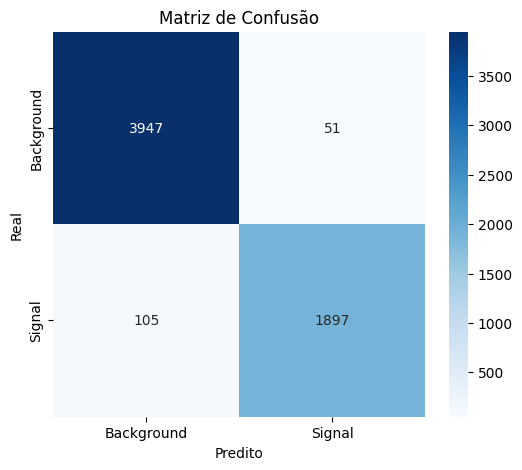

<Figure size 1200x800 with 0 Axes>

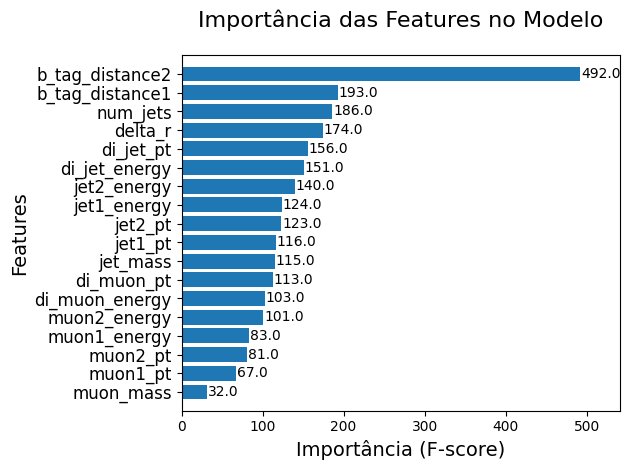

In [4]:
# Importações necessárias
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Definir os nomes das features (mantenha igual ao usado no treinamento)
feature_names = [
    'muon_mass', 'muon1_pt', 'muon2_pt', 'muon1_energy', 'muon2_energy',
    'di_muon_energy', 'di_muon_pt', 'jet_mass', 'jet1_pt', 'jet2_pt',
    'jet1_energy', 'jet2_energy', 'di_jet_energy', 'di_jet_pt', 'delta_r',
    'num_jets', 'b_tag_distance1', 'b_tag_distance2'
]

# 1. Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
print("\n=== Confusion Matrix ===")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot da Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Background', 'Signal'],
            yticklabels=['Background', 'Signal'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# 3. Importância das features com nomes personalizados
plt.figure(figsize=(12, 8))
ax = xgb.plot_importance(model, 
                        max_num_features=18, 
                        height=0.8,
                        importance_type='weight',
                        xlabel='F-score',
                        title='Importância das Features (XGBoost)',
                        grid=False)

# Ajustar os rótulos para usar os nomes corretos
ax.set_yticklabels(feature_names, fontsize=12)
ax.set_xlabel('Importância (F-score)', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.set_title('Importância das Features no Modelo', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

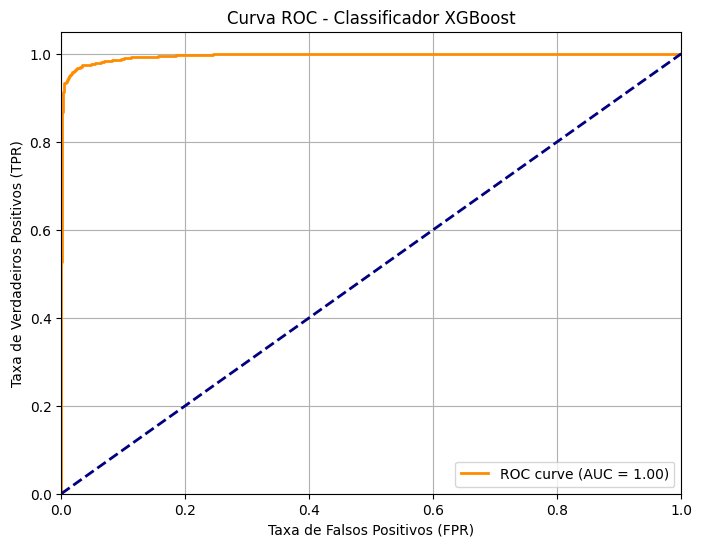


Área sob a curva (AUC): 0.9957


In [5]:
# Importações necessárias
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular as probabilidades da classe positiva (sinal)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Pega apenas as probabilidades da classe 1

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha de referência
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Classificador XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Opcional: Mostrar o valor de AUC numericamente
print(f"\nÁrea sob a curva (AUC): {roc_auc:.4f}")

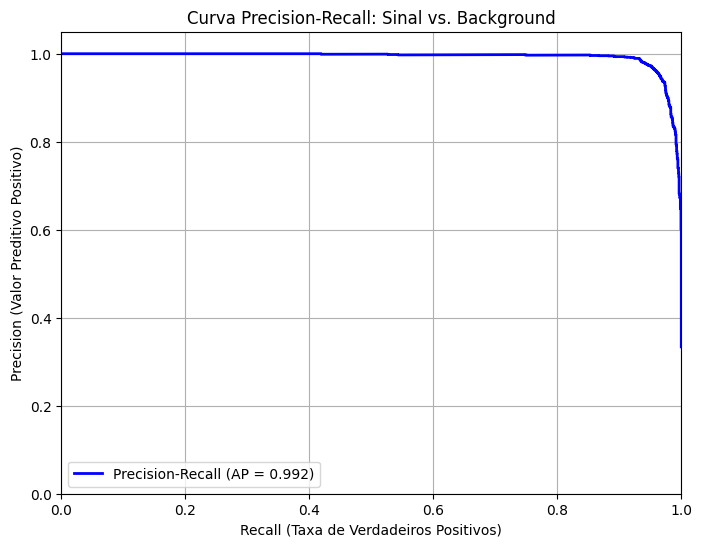


Average Precision (AP): 0.9924
Thresholds usados: [0.00020247 0.00020345 0.00021603 0.00021635 0.00021643]... (total: 5923)


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1. Obter probabilidades da classe positiva (sinal)
y_scores = model.predict_proba(X_test)[:, 1]  # Probabilidades da classe 1 (sinal)

# 2. Calcular Precision, Recall e thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

# 3. Plotar a curva
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall (AP = {avg_precision:.3f})')
plt.xlabel('Recall (Taxa de Verdadeiros Positivos)')
plt.ylabel('Precision (Valor Preditivo Positivo)')
plt.title('Curva Precision-Recall: Sinal vs. Background')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# 4. Informações adicionais (opcional)
print(f"\nAverage Precision (AP): {avg_precision:.4f}")
print(f"Thresholds usados: {thresholds[:5]}... (total: {len(thresholds)})")

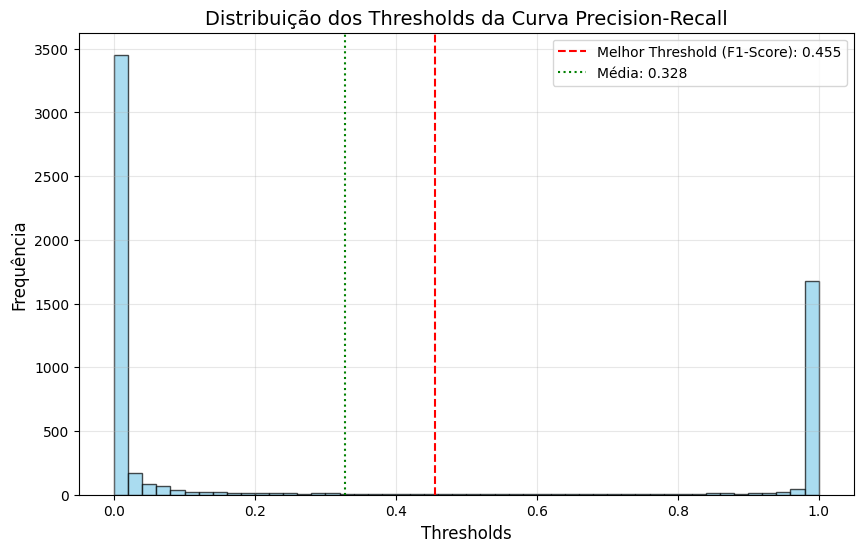


Estatísticas dos Thresholds:
- Número de thresholds: 5923
- Média: 0.3277
- Mediana: 0.0072
- Melhor threshold (F1-Score): 0.4550
- Precision no melhor threshold: 0.9720
- Recall no melhor threshold: 0.9520


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# 1. Obter probabilidades da classe positiva (sinal)
y_scores = model.predict_proba(X_test)[:, 1]  # Probabilidades da classe 1

# 2. Calcular Precision, Recall e Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 3. Histograma dos Thresholds
plt.figure(figsize=(10, 6))

# Histograma principal
n, bins, patches = plt.hist(thresholds, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Thresholds', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Distribuição dos Thresholds da Curva Precision-Recall', fontsize=14)

# Linha vertical para o threshold que maximiza F1-Score
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
plt.axvline(x=best_threshold, color='red', linestyle='--', 
            label=f'Melhor Threshold (F1-Score): {best_threshold:.3f}')

# Linha vertical para a média dos thresholds
mean_threshold = np.mean(thresholds)
plt.axvline(x=mean_threshold, color='green', linestyle=':', 
            label=f'Média: {mean_threshold:.3f}')

plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# 4. Informações estatísticas
print(f"\nEstatísticas dos Thresholds:")
print(f"- Número de thresholds: {len(thresholds)}")
print(f"- Média: {np.mean(thresholds):.4f}")
print(f"- Mediana: {np.median(thresholds):.4f}")
print(f"- Melhor threshold (F1-Score): {best_threshold:.4f}")
print(f"- Precision no melhor threshold: {precision[best_idx]:.4f}")
print(f"- Recall no melhor threshold: {recall[best_idx]:.4f}")

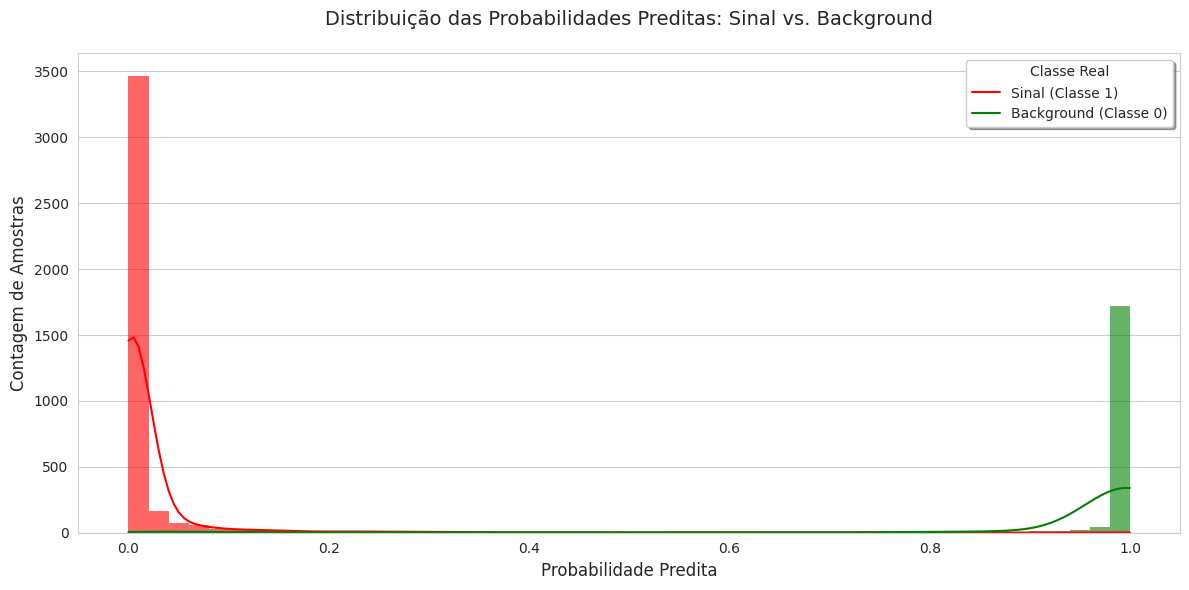

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Obter probabilidades da classe positiva (sinal)
y_scores = model.predict_proba(X_test)[:, 1]

# Criar DataFrame com labels explícitos
df_plot = pd.DataFrame({
    'Probabilidade Predita': y_scores,
    'Classe Real': y_test.replace({0: 'Background (Classe 0)', 1: 'Sinal (Classe 1)'})  # Labels detalhados
})

# Configurar o estilo do gráfico
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plotar histograma com KDE
ax = sns.histplot(
    data=df_plot,
    x='Probabilidade Predita',
    hue='Classe Real',
    bins=50,
    kde=True,
    alpha=0.6,
    palette={'Sinal (Classe 1)': 'green', 'Background (Classe 0)': 'red'},
    edgecolor='none'
)

# Personalizar título e labels
plt.title('Distribuição das Probabilidades Preditas: Sinal vs. Background', fontsize=14, pad=20)
plt.xlabel('Probabilidade Predita', fontsize=12)
plt.ylabel('Contagem de Amostras', fontsize=12)

# Ajustar a legenda
plt.legend(
    title='Classe Real',
    labels=['Sinal (Classe 1)', 'Background (Classe 0)'],  # Garante a ordem correta
    frameon=True,
    shadow=True
)

# Remover linhas de grid verticais para melhor clareza
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()